In [7]:
# Import the required libraries

import torch
import os
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn as nn
import math
import numpy as np
from natsort import natsorted
from PIL import Image
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
# Code to upload dataset to google colab
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import zipfile

    path_to_zip_file = 'drive/MyDrive/data.zip'
    directory_to_extract_to = 'VISCHEMA_PLUS/'
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

    !cp "drive/MyDrive/viscplus_train.csv" "VISCHEMA_PLUS/"
    !cp "drive/MyDrive/viscplus_val.csv" "VISCHEMA_PLUS/"
except:
    print("not on google colab")

not on google colab


In [2]:
# Dataset
class VISCHEMA_PLUS(Dataset):
    def __init__(self, dataset_dir = '../VISCHEMA_PLUS/', image_dir = 'images/', label_dir = 'vms/', train = True, transform = None):
        
        if train:
            train_csv = pd.read_csv(f"{dataset_dir}viscplus_train.csv", header = None)
            all_images = train_csv[0].values.tolist()
        else:
            val_csv = pd.read_csv(f"{dataset_dir}viscplus_val.csv" , header = None)
            all_images = val_csv[0].values.tolist()
            
        self.transform = transform
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.dataset_dir = dataset_dir
        
        self.all_images = natsorted(all_images)
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        convert_tensor = transforms.ToTensor()
        
        image = Image.open(f"{self.dataset_dir}{self.image_dir}{self.all_images[idx]}").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.dataset_dir}{self.label_dir}{self.all_images[idx]}").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

In [8]:
# UNET
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, norm = True, norm_func = nn.InstanceNorm2d):
        super().__init__()
        if norm:
            self.main = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
            )
        else:
            self.main = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.ReLU(),
                norm_func(out_channels),
            )
    def forward(self, x):
        return self.main(x)
    
class Encoder(nn.Module):
    def __init__(self, channels=(3,64,128,256,512), norm_func = nn.InstanceNorm2d):
        super().__init__()
        self.encoding_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1], norm = (i != 0), norm_func = norm_func) for i in range(len(channels)-1)]
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        features = []
        
        for block in self.encoding_blocks:
            x = block(x)
            features.append(x)
            x = self.pool(x)
                 
        return features
        
class Decoder(nn.Module):
    def __init__(self, channels=(512,256,128,64), norm_func = nn.InstanceNorm2d):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(self.channels[i], self.channels[i+1],2,2) for i in range(len(channels)-1)])
        self.decoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1], norm_func = norm_func) for i in range(len(channels)-1)]
        )
    
    def forward(self, x, encoder_features):
        for i in range(len(self.channels)-1):
            x = self.upconvs[i](x)
            features = self.crop(encoder_features[i], x)
            x = torch.cat([x, features], dim=1)
            x = self.decoder_blocks[i](x)
        return x
    
    def crop(self, features, x):
        _, _, height, width = x.shape
        features = transforms.CenterCrop([height, width])(features)
        return features
        
class Generator(nn.Module):
    def __init__(self, 
                 encode_channels=(3,64,128,256,512,1024), 
                 decode_channels=(1024,512,256,128,64), 
                 num_class=3, 
                 retain_dim=True, 
                 output_size=(572,572),
                 norm_func = nn.InstanceNorm2d):
        
        super(Generator, self).__init__()
        
        self.encoder = Encoder(encode_channels, norm_func = norm_func)
        self.decoder = Decoder(decode_channels, norm_func = norm_func)
        
        self.head = nn.Conv2d(decode_channels[-1], num_class, 1)
        
        """# Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)"""

    def forward(self, x):
        
        encoding_features = self.encoder(x)
        decoding_features = self.decoder(encoding_features[::-1][0], encoding_features[::-1][1:])
        output = self.head(decoding_features)
        output = nn.Tanh()(output)
        
        return output

In [9]:
# Set up our training environment

# Dataloaders
batch_size = 8
image_transforms = transforms.Compose([
    transforms.Resize(128, antialias=True),
    transforms.Normalize(0.5,0.5)
])

train_dataset = VISCHEMA_PLUS(transform = image_transforms, train=True)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
print(f'{len(train_dataset)} Items in Train dataset')

val_dataset   = VISCHEMA_PLUS(transform = image_transforms, train=False)
val_loader   = DataLoader(dataset = val_dataset,   batch_size = batch_size, shuffle=True)
print(f'{len(val_dataset)}  Items in Validation dataset')

# Network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Generator().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in UNet')

# Training
loss_func = nn.L1Loss(reduction = 'mean')
optim = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 80

# Logging
training_losses = []
val_losses = []
best_val_loss = 10000
run_name = "run2"
os.makedirs(os.path.dirname(f"checkpoints/{run_name}/"), exist_ok=True) 

1280 Items in Train dataset
320  Items in Validation dataset
31031875 Parameters in UNet


In [66]:
# Training Loop
print('Starting Training')
for epoch in range(1,num_epochs+1):
            
    # Go into training mode
    model.train()
    total_train_loss = 0
    total_val_loss = 0

    for i, (images, labels) in enumerate(train_loader):
    
        # Move images to device and create prediction
        images, labels = images.to(device), labels.to(device)
        output = model(images)
    
        #Evaluate the loss of our model and take a step
        loss = loss_func(output,labels)
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Logging
        total_train_loss += loss*images.shape[0]
        
        del images, labels, output
        torch.cuda.empty_cache()

    total_train_loss /= len(train_dataset)
    training_losses.append(total_train_loss.item())

    # Evaluate the model on the val set
    # Reset counters and switch to eval mode
    model.eval()

    with torch.no_grad():
        for i , (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_func(output,labels)

            # Logging
            total_val_loss += loss*images.shape[0]
            
            del images, labels, output
            
    total_val_loss /= len(val_dataset)        
    val_losses.append(total_val_loss.item()) 
    
    # Checkpoint weights and losses
    if total_val_loss < best_val_loss:
        torch.save(model.state_dict(), f'checkpoints/{run_name}/best_weights.pkl')
        best_val_loss = total_val_loss

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'checkpoints/{run_name}/{epoch}.pkl')

    with open(f"checkpoints/{run_name}/train_losses.pkl", "wb") as f:
        pickle.dump(training_losses, f)
    with open(f"checkpoints/{run_name}/val_losses.pkl", "wb") as f:
        pickle.dump(val_losses, f)

    print(f'Epoch [{epoch}/{num_epochs}],Train Loss: {total_train_loss}, Val Loss: {total_val_loss}')

Starting Training
Epoch [1/80],Train Loss: 0.32881173491477966, Val Loss: 0.23606203496456146
Epoch [2/80],Train Loss: 0.21684415638446808, Val Loss: 0.20412038266658783
Epoch [3/80],Train Loss: 0.19065281748771667, Val Loss: 0.18755052983760834
Epoch [4/80],Train Loss: 0.18321222066879272, Val Loss: 0.17919684946537018
Epoch [5/80],Train Loss: 0.17609338462352753, Val Loss: 0.17744280397891998
Epoch [6/80],Train Loss: 0.16818152368068695, Val Loss: 0.17359882593154907
Epoch [7/80],Train Loss: 0.16282787919044495, Val Loss: 0.17270244657993317
Epoch [8/80],Train Loss: 0.15976747870445251, Val Loss: 0.1634456217288971
Epoch [9/80],Train Loss: 0.15965351462364197, Val Loss: 0.165845587849617
Epoch [10/80],Train Loss: 0.15454040467739105, Val Loss: 0.15903989970684052
Epoch [11/80],Train Loss: 0.15628187358379364, Val Loss: 0.1611364185810089
Epoch [12/80],Train Loss: 0.15306833386421204, Val Loss: 0.16217882931232452
Epoch [13/80],Train Loss: 0.19739073514938354, Val Loss: 0.189221054315

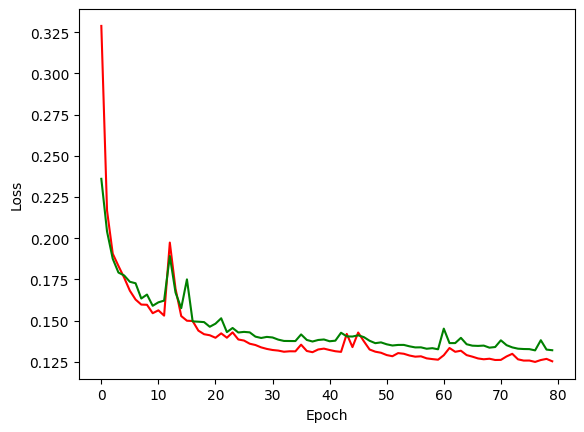

In [10]:
# Plot losses
with open(f"checkpoints/{run_name}/train_losses.pkl", "rb") as f:
    training_losses = pickle.load(f)
with open(f"checkpoints/{run_name}/val_losses.pkl", "rb") as f:
    val_losses = pickle.load(f)

#plt.title("Training curve")

plt.plot(range(len(training_losses)),training_losses,'r')
plt.plot(range(len(val_losses)),val_losses,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [11]:
print(min(training_losses))

0.12498454004526138


In [6]:
model.load_state_dict(torch.load(f"checkpoints/{run_name}/best_weights.pkl"))

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/run2/best_weights.pkl'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


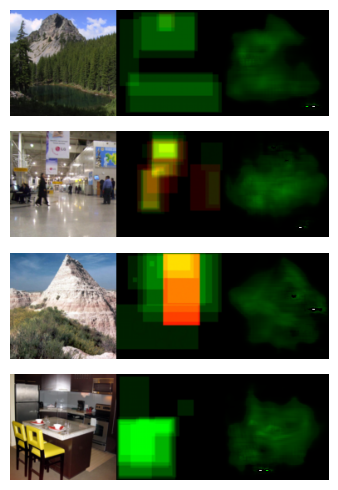

In [69]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(5,5))
cols, rows = 2, 2

for i in range(rows):

    images, labels = next(iter(val_loader))
    images= images.to(device)
    output = model(images)

    display = torch.cat([images.to("cpu"), labels, output.to("cpu").detach()], dim=3)

    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow((display[0].squeeze().permute(1, 2, 0) +1 )/2 )

    
plt.tight_layout()
plt.show()

In [70]:
# Find best and worst outputs

# List of all images
val_csv = pd.read_csv(f"{'../VISCHEMA_PLUS/'}viscplus_val.csv" , header = None)
all_images = val_csv[0].values.tolist()
all_images = natsorted(all_images)
image_scores = {}

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(128, antialias=True),
    transforms.Normalize(0.5,0.5)
])

# Loop over all images
for image_path in all_images:
    
    image = image_transforms(Image.open(f"../VISCHEMA_PLUS/images/{image_path}").convert("RGB")).to(device)
    label = image_transforms(Image.open(f"../VISCHEMA_PLUS/vms/{image_path}").convert("RGB")).to(device)
    image, label = image[None, :], label[None, :]
    output = model(image)
    loss = loss_func(label, output)
    image_scores[image_path] = loss.item()

    del image, label, output, loss

# Sort the scores
best_image_scores   = sorted(image_scores.items(), key = lambda x:x[1], reverse=False)
worst_image_scores  = sorted(image_scores.items(), key = lambda x:x[1], reverse=True)

In [71]:
print(image_scores)
print(best_image_scores)
print(worst_image_scores)

{'sun_aabjtppsnozdurdt.jpg': 0.09163518995046616, 'sun_aaeggavxrhahhhsp.jpg': 0.09025200456380844, 'sun_aaggckrhlbnenekd.jpg': 0.06980538368225098, 'sun_aamdtqvmzkmjgivi.jpg': 0.05015301704406738, 'sun_aaovkqlsvacznbgr.jpg': 0.14289012551307678, 'sun_aarrcygkwuzaeiuk.jpg': 0.09860691428184509, 'sun_aarzwginlqrfnzvf.jpg': 0.06275815516710281, 'sun_aasothdstfehplzt.jpg': 0.08753825724124908, 'sun_aatcxjrhafurspvj.jpg': 0.04326969385147095, 'sun_aauyknaheebshrxq.jpg': 0.17216813564300537, 'sun_abcwfshruftobgfp.jpg': 0.04828023537993431, 'sun_abxrfrucnptodioj.jpg': 0.2510499656200409, 'sun_acfgivghaydjibik.jpg': 0.4276179075241089, 'sun_acgxzrlwjgdzipip.jpg': 0.1659013032913208, 'sun_aciofoesudrskhdm.jpg': 0.13444338738918304, 'sun_adbmrbyhsdystkhh.jpg': 0.1259332001209259, 'sun_adoqbnxbotablpwl.jpg': 0.18885843455791473, 'sun_adqndcjxpptvizjl.jpg': 0.09845831990242004, 'sun_aeisjcbguuqtsivg.jpg': 0.11127237975597382, 'sun_aekkynucosyodgdj.jpg': 0.1920827329158783, 'sun_aelpnoofufvvqqhf.jp

image: sun_bthnehnrbwlwuyzt.jpg loss: 0.0388956293463707
image: sun_aybpvlbbsnxxwjmm.jpg loss: 0.04160470515489578
image: sun_bqkwmxoqnqvjsblj.jpg loss: 0.04210078716278076
image: sun_aatcxjrhafurspvj.jpg loss: 0.04326969385147095


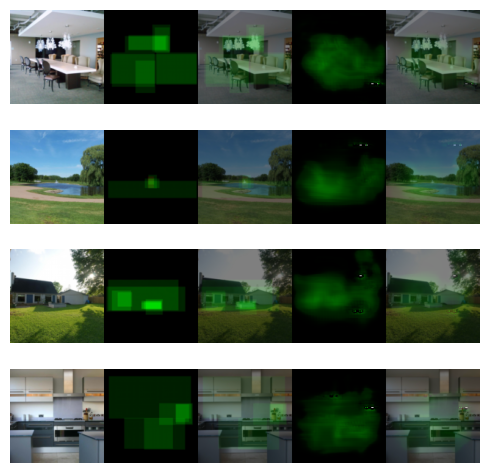

In [72]:
# Display boilerplate
figure = plt.figure(figsize=(5,5))
cols, rows = 1, 4

# Show the best
for i in range(rows):
    
    image_path   = best_image_scores[i][0]
    print(f"image: {best_image_scores[i][0]} loss: {best_image_scores[i][1]}")
    image        = image_transforms(Image.open(f"../VISCHEMA_PLUS/images/{image_path}").convert("RGB")).to(device)
    label        = image_transforms(Image.open(f"../VISCHEMA_PLUS/vms/{image_path}").convert("RGB")).to(device)
    image, label = image[None, :], label[None, :]
    output       = model(image)

    ideal        = torch.add(image, label)/2
    output_cat   = torch.add(image, output)/2

    display      = (torch.cat([image.to("cpu"), label.to("cpu"), ideal.to("cpu").detach(), output.to("cpu").detach(), output_cat.to("cpu").detach()], dim=3) + 1)/2
    display      = display.clip(0,1)

    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(display[0].squeeze().permute(1, 2, 0) )

    
plt.tight_layout()
plt.show()

image: sun_bthnehnrbwlwuyzt.jpg loss: 0.0388956293463707
image: sun_aybpvlbbsnxxwjmm.jpg loss: 0.04160470515489578
image: sun_bqkwmxoqnqvjsblj.jpg loss: 0.04210078716278076
image: sun_aatcxjrhafurspvj.jpg loss: 0.04326969385147095


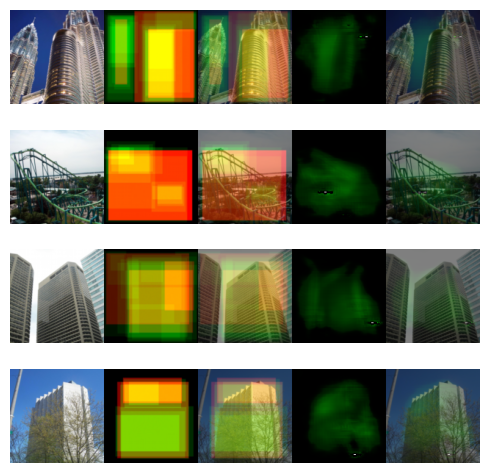

In [73]:
# Display boilerplate
figure = plt.figure(figsize=(5,5))
cols, rows = 1, 4

# Show the worst
for i in range(rows):

    image_path   = worst_image_scores[i][0]
    print(f"image: {best_image_scores[i][0]} loss: {best_image_scores[i][1]}")
    image        = image_transforms(Image.open(f"../VISCHEMA_PLUS/images/{image_path}").convert("RGB")).to(device)
    label        = image_transforms(Image.open(f"../VISCHEMA_PLUS/vms/{image_path}").convert("RGB")).to(device)
    image, label = image[None, :], label[None, :]
    output       = model(image)

    ideal        = torch.add(image, label)/2
    output_cat   = torch.add(image, output)/2

    display      = (torch.cat([image.to("cpu"), label.to("cpu"), ideal.to("cpu").detach(), output.to("cpu").detach(), output_cat.to("cpu").detach()], dim=3) + 1)/2
    display      = display.clip(0,1)

    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow( display[0].squeeze().permute(1, 2, 0))

    
plt.tight_layout()
plt.show()